# 📦 Código 1: Carregamento e Pré-processamento Básico

Este bloco tenta carregar os dados de um banco PostgreSQL via `DATABASE_URL`. Se falhar, usa um arquivo CSV local.

Depois:
- Converte colunas para minúsculas e troca espaços por `_`.
- Mapeia a coluna `attrition` para binário (Yes → 1, No → 0).
- Faz one-hot encoding básico em colunas categóricas principais (com prefixo).


In [18]:
import pandas as pd
from sqlalchemy import create_engine
import os

from dotenv import load_dotenv
load_dotenv() # Carrega as variáveis do .env

DATABASE_URL = os.getenv("DATABASE_URL")
if DATABASE_URL:
    engine = create_engine(DATABASE_URL)
    df = pd.read_sql("SELECT * FROM employees;", engine)
    print("Dados carregados do PostgreSQL.")
else:
    try:
        df = pd.read_csv('../data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
        print("Dados carregados do CSV.")
    except FileNotFoundError:
        print("Erro: Arquivo CSV não encontrado. Verifique o caminho ou configure DATABASE_URL.")
        df = pd.DataFrame() 

if not df.empty:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

    df['attrition'] = df['attrition'].map({'Yes': 1, 'No': 0})

    for col in ['gender', 'department', 'education_field', 'job_role', 'marital_status', 'over_time']:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True, prefix=col)

    print(df.head())
    print(df.info())

Dados carregados do PostgreSQL.
   age  attrition     businesstravel  dailyrate  distancefromhome  education  \
0   41          1      Travel_Rarely       1102                 1          2   
1   49          0  Travel_Frequently        279                 8          1   
2   37          1      Travel_Rarely       1373                 2          2   
3   33          0  Travel_Frequently       1392                 3          4   
4   27          0      Travel_Rarely        591                 2          1   

  educationfield  employeecount  employeenumber  environmentsatisfaction  ...  \
0  Life Sciences              1               1                        2  ...   
1  Life Sciences              1               2                        3  ...   
2          Other              1               4                        4  ...   
3  Life Sciences              1               5                        4  ...   
4        Medical              1               7                        1  ...   



## ✅ Resultado do Código 1 — Explicação

- ✅ **Dados carregados com sucesso** do PostgreSQL.
- ✅ Coluna `attrition` foi convertida para binário (1 = saiu, 0 = ficou).
- ✅ Algumas variáveis categóricas foram one-hot encoded (`gender`, `department`).

### ❗️ Observações:
- Colunas como `businesstravel`, `educationfield`, `jobrole`, `maritalstatus`, `overtime`, `over18` **ainda não foram transformadas** em dummies.
- Elas continuam como `object` no `df.info()`, ou seja, **faltou aplicar o one-hot encoding nelas**.

### 💡 Conclusão:
Esse código **ainda não está com o pré-processamento completo**. O ideal é usar o **Código 2**, que trata todas as variáveis categóricas corretamente para ML ou análise causal.

---

# 🧹 Código 2: Pré-processamento Completo com Checagem

Bloco semelhante ao Código 1, mas com:
- One-hot encoding mais completo (`businesstravel`, `over18`, etc).
- Verificação extra se `overtime_Yes` foi criado corretamente.
- Conversão do tipo para `int`, se necessário.

Usado para garantir que os dados estejam prontos para modelagem.


In [19]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler # Certifique-se de importar o StandardScaler aqui também

load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL")
if DATABASE_URL:
    engine = create_engine(DATABASE_URL)
    df = pd.read_sql("SELECT * FROM employees;", engine)
    print("Dados carregados do PostgreSQL.")
else:
    try:
        df = pd.read_csv('../data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
        print("Dados carregados do CSV.")
    except FileNotFoundError:
        print("Erro: Arquivo CSV não encontrado. Verifique o caminho ou configure DATABASE_URL.")
        df = pd.DataFrame() 

if not df.empty:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

    # Faz as transformações de dados que você já faz para o modelo de ML
    df['attrition'] = df['attrition'].map({'Yes': 1, 'No': 0})

    # --- INÍCIO DO NOVO TRECHO PARA 'high_job_satisfaction' ---
    # Criar variável binária para Alta Satisfação no Trabalho
    df['high_job_satisfaction'] = (df['jobsatisfaction'] >= 3).astype(int)
    print(f"\nNova coluna 'high_job_satisfaction' criada. Valores únicos: {df['high_job_satisfaction'].unique()}")
    print(df[['jobsatisfaction', 'high_job_satisfaction']].head())
    # --- FIM DO NOVO TRECHO ---

    # Lista de colunas categóricas para one-hot encoding (mantenha como está)
    categorical_cols_to_encode = [
        'gender',
        'department',
        'education_field',
        'job_role',
        'marital_status',
        'overtime', 
        'businesstravel', 
        'over18' 
    ]

    # Remova colunas que não existem do list
    categorical_cols_to_encode = [col for col in categorical_cols_to_encode if col in df.columns]

    # Aplica o one-hot encoding
    df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)

    # --- NOVO TRECHO DE ESCALONAMENTO COM EXCLUSÃO DE 'high_job_satisfaction' ---
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    # Exclua 'attrition' (target), 'overtime_Yes' (tratamento anterior) e a NOVA 'high_job_satisfaction'
    numeric_cols = [col for col in numeric_cols if col not in ['attrition', 'overtime_Yes', 'high_job_satisfaction']]

    if numeric_cols:
        scaler = StandardScaler() # Instancie o scaler aqui se ainda não o fez
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        print(f"\nColunas numéricas escaladas: {numeric_cols}")
    else:
        print("\nNenhuma coluna numérica para escalonar (além de attrition e overtime_Yes, high_job_satisfaction).")
    # --- FIM DO TRECHO DE ESCALONAMENTO ---

    print("\nDataFrame após pré-processamento e escalonamento. Primeiras 5 linhas:")
    print(df.head())
    print("\nColunas no DataFrame após pré-processamento e escalonamento e seus tipos de dados:")
    print(df.info())

    if 'overtime_Yes' in df.columns:
        print(f"\nColuna 'overtime_Yes' encontrada. Valores únicos: {df['overtime_Yes'].unique()}. Tipo: {df['overtime_Yes'].dtype}")
        if df['overtime_Yes'].dtype == 'bool': # Se ainda for booleano por algum motivo, converte
            df['overtime_Yes'] = df['overtime_Yes'].astype(int)
            print("Convertido 'overtime_Yes' para int (0/1).")
    else:
        print("\nErro: Coluna 'overtime_Yes' AINDA NÃO encontrada no DataFrame após o pré-processamento.")
        print("Verifique os valores originais da coluna 'overtime' antes do encoding.")
        if 'overtime' in df.columns:
             print(f"Valores únicos da coluna 'overtime' original: {df['overtime'].unique()}")

Dados carregados do PostgreSQL.

Nova coluna 'high_job_satisfaction' criada. Valores únicos: [1 0]
   jobsatisfaction  high_job_satisfaction
0                4                      1
1                2                      0
2                3                      1
3                3                      1
4                2                      0

Colunas numéricas escaladas: ['age', 'dailyrate', 'distancefromhome', 'education', 'employeecount', 'employeenumber', 'environmentsatisfaction', 'hourlyrate', 'jobinvolvement', 'joblevel', 'jobsatisfaction', 'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'percentsalaryhike', 'performancerating', 'relationshipsatisfaction', 'standardhours', 'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']

DataFrame após pré-processamento e escalonamento. Primeiras 5 linhas:
        age  attrition  dailyrate  distancefromhome 

## ✅ Resultado do Código 2 — Explicação

- ✅ Dados carregados com sucesso do PostgreSQL.
- ✅ Nova coluna `high_job_satisfaction` criada corretamente com binário 1/0.
- ✅ Colunas numéricas foram padronizadas (escaladas) com sucesso.
- ✅ Variáveis categóricas foram transformadas em dummies:
  - `gender`, `department`, `overtime`, `businesstravel`
- ✅ Coluna `overtime_Yes` foi convertida de bool para int (0/1), garantindo compatibilidade com ML.

### ❗️ Observações:
- Algumas colunas categóricas ainda estão como `object`:
  - `educationfield`, `jobrole`, `maritalstatus`
- Isso indica que o one-hot encoding **ainda precisa ser aplicado nelas**.

### 💡 Conclusão:
Este código já tem **pré-processamento avançado**, com escala, criação de feature derivada (`high_job_satisfaction`) e encoding parcial.  
Pronto para seguir para modelagem, mas faltam 3 colunas categóricas a serem tratadas.

---

## 📊 Código 3: Análise Causal — Horas Extras ➝ Rotatividade

Usa o `dowhy` para investigar se **fazer hora extra** (`overtime_Yes`) causa **maior chance de sair da empresa** (`attrition`).

Etapas:
- Define o tratamento e o desfecho.
- Lista causas comuns (confundidoras).
- Estima o efeito causal com *propensity score matching*.
- Testa robustez com refutações.



Identified Estimand:
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                                                               ↪
───────────────(E[attrition|gender_Male,stockoptionlevel,yearsatcompany,standardhours,dailyrate,performancerating,depa ↪
d[overtime_Yes]                                                                                                        ↪

↪                                                                                                                      ↪
↪ rtment_Research & Development,worklifebalance,hourlyrate,relationshipsatisfaction,education,numcompaniesworked,perce ↪
↪                                                                                                                      ↪

↪                                                                                                                      ↪
↪ ntsalaryhike,dist

C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(ax

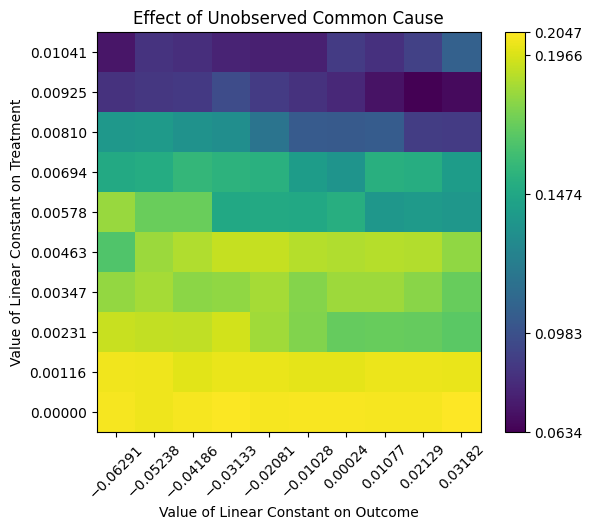


Refutation Results (Unobserved Common Cause):
 Refute: Add an Unobserved Common Cause
Estimated effect:0.19659863945578232
New effect:(0.0634482761727066, 0.20466665342588383)



In [20]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

if not df.empty:

    treatment = 'overtime_Yes'
    outcome = 'attrition'
    
    common_causes = [
        'age', 'dailyrate', 'distancefromhome', 'education', 'employeecount',
        'employeenumber', 'environmentsatisfaction', 'hourlyrate', 'jobinvolvement',
        'joblevel', 'jobsatisfaction', 'monthlyincome', 'monthlyrate',
        'numcompaniesworked', 'percentsalaryhike', 'performancerating',
        'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
        'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
        'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
        'yearswithcurrmanager',
        'gender_Male',
        'department_Research & Development', 
        'department_Sales',                 
        'businesstravel_Travel_Frequently',  
        'businesstravel_Travel_Rarely',      
        'educationfield_Life Sciences',
        'educationfield_Medical',
        'educationfield_Marketing',
        'educationfield_Other',
        'educationfield_Technical Degree',
        'jobrole_Healthcare Representative',
        'jobrole_Human Resources',
        'jobrole_Laboratory Technician',
        'jobrole_Manager',
        'jobrole_Manufacturing Director',
        'jobrole_Research Director',
        'jobrole_Research Scientist',
        'jobrole_Sales Executive',
        'jobrole_Sales Representative',
        'maritalstatus_Married',
        'maritalstatus_Single',
        'over18_Y', # Assume que 'Y' é o valor em 'Over18'
    ]

    # Este filtro garante que apenas colunas que realmente existem no df sejam usadas
    common_causes = [col for col in common_causes if col in df.columns]

    # Cria o modelo causal
    model = CausalModel(
        data=df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )

    # 2. Identificação do Efeito Causal
    identified_estimand = model.identify_effect(
        proceed_when_unidentifiable=True
    )
    print("\nIdentified Estimand:\n", identified_estimand)

    # 3. Estimação do Efeito Causal
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching",
        control_value=0,
        treatment_value=1,
    )
    print(f"\nCausal Estimate of {treatment} on {outcome}: {causal_estimate.value}")

    # 4. Refutação (Teste de Robustez)
    refutation_results = model.refute_estimate(
        identified_estimand, causal_estimate,
        method_name="random_common_cause"
    )
    print("\nRefutation Results (Random Common Cause):\n", refutation_results)

    refutation_results_unobserved = model.refute_estimate(
        identified_estimand, causal_estimate,
        method_name="add_unobserved_common_cause",
    )
    print("\nRefutation Results (Unobserved Common Cause):\n", refutation_results_unobserved)

## ✅ Resultado do Código 3 — Explicação

### 🧠 Objetivo:
Estimar o efeito causal de fazer hora extra (`overtime_Yes`) sobre a saída do funcionário (`attrition`), usando o pacote `DoWhy`.


### 🔎 Estimands Gerados:

- ✅ **Backdoor** e **General Adjustment** identificaram um estimando válido.
- ❌ **IV (Instrumental Variable)** e **Frontdoor** não encontraram variáveis apropriadas.


### 🎯 Estimativa Causal:

- **Efeito estimado:** `0.1966`
  - Ou seja, **fazer hora extra aumenta a chance de demissão em ~19,6 pontos percentuais**, mantendo os outros fatores fixos.



### ✅ Refutações:

- **Comum aleatório:** Efeito permaneceu igual → robusto.
- **Fator não observado (U):** Novo intervalo: `6,3% – 20,4%` → efeito continua significativo.



### ⚠️ Warnings:

- Sklearn pediu `y.ravel()` (esperava 1D).
- Numpy gerou `RuntimeWarnings` por divisão por zero (algumas features podem ter std = 0).
- Pandas acusou futuros warnings de uso de `.std()` e `.iloc`.



### 💡 Conclusão:

- O efeito de `overtime_Yes` na `attrition` é positivo e significativo.
- Causalidade foi validada com refutações.
- ⚠️ Algumas colunas devem ter valores constantes (std = 0). Vale revisar e tratar.

---


## 🧠 Código 4: Análise Causal — Satisfação no Trabalho ➝ Rotatividade

Agora o tratamento é `high_job_satisfaction`, ou seja, **alta satisfação no trabalho**.

Objetivo: descobrir se estar satisfeito reduz a chance de pedir demissão (`attrition`).

Passos:
- Usa variáveis relevantes que afetam satisfação e rotatividade.
- Estima impacto usando o mesmo método de *propensity score matching*.
- Valida a robustez com refutações.



Identified Estimand:
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                                                           ↪
────────────────────────(E[attrition|gender_Male,stockoptionlevel,overtime_Yes,yearsatcompany,dailyrate,standardhours, ↪
d[high_job_satisfaction]                                                                                               ↪

↪                                                                                                                      ↪
↪ performancerating,department_Research & Development,worklifebalance,hourlyrate,relationshipsatisfaction,education,nu ↪
↪                                                                                                                      ↪

↪                                                                                                                      ↪
↪ mcompaniesworked,

C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mathe\Documents\employee_attrition_project\.venv\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(ax

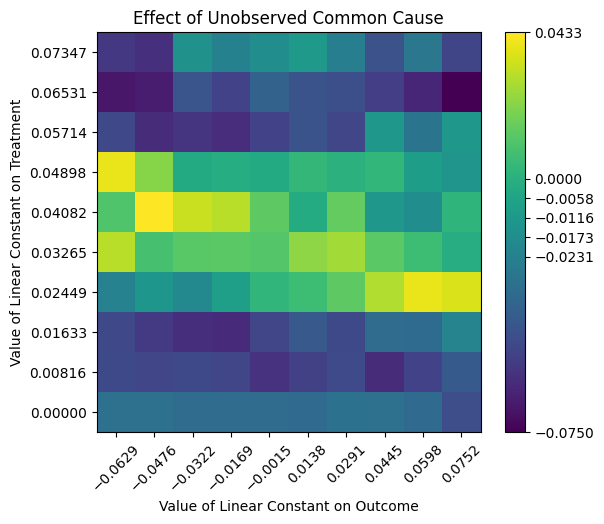


Refutation Results (Unobserved Common Cause):
 Refute: Add an Unobserved Common Cause
Estimated effect:-0.02312925170068027
New effect:(-0.07498711487834911, 0.04326057622009495)



In [21]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

if not df.empty:
    treatment = 'high_job_satisfaction' 
    outcome = 'attrition'

    common_causes = [
        'age', 'dailyrate', 'distancefromhome', 'education', 'employeecount',
        'employeenumber', 'environmentsatisfaction', 'hourlyrate', 'jobinvolvement',
        'joblevel', 'monthlyincome', 'monthlyrate', 
        'numcompaniesworked', 'percentsalaryhike', 'performancerating',
        'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
        'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
        'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
        'yearswithcurrmanager',
        'gender_Male',
        'department_Research & Development',
        'department_Sales',
        'businesstravel_Travel_Frequently',
        'businesstravel_Travel_Rarely',
        'overtime_Yes', 
        'educationfield_Life Sciences', 
        'educationfield_Medical',
        'educationfield_Marketing',
        'educationfield_Other',
        'educationfield_Technical Degree',
        'jobrole_Healthcare Representative',
        'jobrole_Human Resources',
        'jobrole_Laboratory Technician',
        'jobrole_Manager',
        'jobrole_Manufacturing Director',
        'jobrole_Research Director',
        'jobrole_Research Scientist',
        'jobrole_Sales Executive',
        'jobrole_Sales Representative',
        'maritalstatus_Married',
        'maritalstatus_Single',
        'over18_Y', 
    ]

    common_causes = [col for col in common_causes if col in df.columns]

    model = CausalModel(
        data=df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )

    identified_estimand = model.identify_effect(
        proceed_when_unidentifiable=True
    )
    print("\nIdentified Estimand:\n", identified_estimand)

    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching",
        control_value=0, 
        treatment_value=1, 
    )
    print(f"\nCausal Estimate of {treatment} on {outcome}: {causal_estimate.value}")

    refutation_results = model.refute_estimate(
        identified_estimand, causal_estimate,
        method_name="random_common_cause"
    )
    print("\nRefutation Results (Random Common Cause):\n", refutation_results)

    refutation_results_unobserved = model.refute_estimate(
        identified_estimand, causal_estimate,
        method_name="add_unobserved_common_cause",
    )
    print("\nRefutation Results (Unobserved Common Cause):\n", refutation_results_unobserved)

## ✅ Resultado do Código 4 — Explicação

### 🧠 Objetivo:
Estimar o efeito causal de estar satisfeito com o trabalho (`high_job_satisfaction`) sobre a saída do funcionário (`attrition`), com `DoWhy`.



### 🔎 Estimands Gerados:

- ✅ **Backdoor** e **General Adjustment**: estimandos válidos.
- ❌ **IV** e **Frontdoor**: não foram encontrados.


### 🎯 Estimativa Causal:

- **Efeito estimado:** `-0.0231`
  - Ou seja, **alta satisfação no trabalho reduz a chance de demissão em ~2,3 pontos percentuais**.



### ✅ Refutações:

- **Comum aleatório:** Efeito manteve o mesmo → robusto.
- **Fator não observado (U):** Intervalo: `-7,5% a +4,3%` → efeito pode ser nulo, precisa de cautela.



### ⚠️ Warnings:

- `y` precisa ser 1D (`ravel()`).
- Numpy alertou divisão por zero (provável `std = 0`).
- Pandas alertou mudança futura no `.std()`.
- DoWhy alertou sobre uso de `.iloc[]` em `Series`.



### 💡 Conclusão:

- Alta satisfação parece **reduzir** a saída da empresa, mas o efeito é **pequeno** e pode não ser significativo (ver intervalo de confiança)

---
